In [1]:
import os
import json
import subprocess
import numpy as np
import pandas as pd
import pickle as pkl
import nibabel as nib
import scipy.io as sio
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from os.path import join as pjoin
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from nilearn.glm.first_level import make_first_level_design_matrix

mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams.update({'font.size': 12, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})

# generate surface map for tSNR
def save_ciftifile(data, filename):
    template = '/nfs/z1/zhenlab/BrainImageNet/NaturalObject/data/bold/Analysis_derivatives/ciftify/sub-core02/MNINonLinear/Results/ses-ImageNet01_task-object_run-1/ses-ImageNet01_task-object_run-1_Atlas.dtseries.nii'
    ex_cii = nib.load(template)
    ex_cii.header.get_index_map(0).number_of_series_points = 1
    # check data shape
    if data.shape[0] == 59412:
        brain_map = np.zeros(91282)
        brain_map[:59412] = data
    else:
        brain_map = data
    brain_map = brain_map[np.newaxis, :]
    nib.save(nib.Cifti2Image(brain_map.astype(np.float32), ex_cii.header), filename)

# define path
beta_path = '/nfs/z1/zhenlab/BrainImageNet/action/data/bold/derivatives/beta'
fmriprep_path = '/nfs/z1/zhenlab/BrainImageNet/action/data/bold/derivatives/fmriprep'
ciftify_path = '/nfs/z1/zhenlab/BrainImageNet/action/data/bold/derivatives/ciftify'
nifti_path = '/nfs/z1/zhenlab/BrainImageNet/action/data/bold/nifti'
result_path = '/nfs/z1/userhome/ZhouMing/workingdir/BIN/action/utils/HAD/result'

/usr/local/neurosoft/anaconda3/lib/python3.8/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


In [2]:
from scipy.stats import pearsonr

# Load beta for 30 subjects 
sub_names = sorted([i for i in os.listdir(beta_path) if i.startswith('sub')])
mask_sum = ['EVC', 'VTC', 'LO', 'AIP']
n_sub = len(sub_names)
n_class = 180

beta_sum = np.zeros((n_sub, n_class, 59412))
for sub_idx, sub_name in enumerate(sub_names):
    # define beta path
    beta_sub_path = pjoin(beta_path, sub_name, f'{sub_name}_action-beta_clean.npy')
    beta_sub = np.load(beta_sub_path)
    scaler = StandardScaler()
    beta_sum[sub_idx] = scaler.fit_transform(beta_sub)
    print(f'Finish {sub_name}')

# beta_sum = beta_sum.mean(axis=0)

Finish sub-01
Finish sub-02
Finish sub-03
Finish sub-04
Finish sub-05
Finish sub-06
Finish sub-07
Finish sub-08
Finish sub-09
Finish sub-10
Finish sub-11
Finish sub-12
Finish sub-13
Finish sub-14
Finish sub-15
Finish sub-16
Finish sub-17
Finish sub-18
Finish sub-19
Finish sub-20
Finish sub-21
Finish sub-22
Finish sub-23
Finish sub-24
Finish sub-25
Finish sub-26
Finish sub-27
Finish sub-28
Finish sub-29
Finish sub-30


In [3]:
# load animacy labels
beh_path = '/nfs/z1/userhome/ZhouMing/workingdir/BIN/utils/action_spaces/behavior'
beh_df = pd.read_csv(pjoin(beh_path, 'dim_scores.csv'), index_col=0)
beh_df['mean_score'] = beh_df.iloc[:, 2:].mean(axis=1)
beh_df = beh_df.drop(beh_df.columns[2:22], axis=1)
beh_df = beh_df.sort_values(by='class')
beh_df = beh_df[(beh_df['dim']=='sociality') | (beh_df['dim']=='transitivity')]

In [6]:
from scipy.stats import pearsonr

soc_df = beh_df[(beh_df['dim']=='sociality')]
tra_df = beh_df[(beh_df['dim']=='transitivity')]
print(pearsonr(soc_df['mean_score'].to_numpy(), tra_df['mean_score'].to_numpy()))

PearsonRResult(statistic=-0.1582378033487074, pvalue=0.033873204359359595)


#### Show brain map of transitivity and sociality based on extremum categories from behavior score

In [5]:
from scipy.stats import pearsonr
n_check = 30
dims = ['sociality', 'transitivity']
action_selected = pd.DataFrame()
map_path = pjoin(result_path, 'brain_map')
brain_map_compare = np.zeros((2, 59412))

for dim_idx, dim in enumerate(dims):
    dim_df = beh_df.loc[(beh_df['dim']==dim), :]
    dim_df.reset_index(drop=True, inplace=True)
    dim_df.sort_values(by='mean_score', inplace=True)
    # extract category info
    low_category_name = dim_df.iloc[:n_check, 0].to_list()
    low_category_idx = dim_df.index.to_list()[:n_check]
    high_category_name = dim_df.iloc[-n_check:, 0].to_list()
    high_category_idx = dim_df.index.to_list()[-n_check:]
    # print(f'Category name in {dim}\n'+ 'high:', high_category_name, '\nlow:', low_category_name)
    # save into dataframe
    action_selected[f'{dim}_high'] = high_category_name
    action_selected[f'{dim}_low'] = low_category_name
    # compute brain map
    brain_map = np.zeros((1, 91282))
    brain_map[0, :59412] = beta_sum[high_category_idx].mean(axis=0) - beta_sum[low_category_idx].mean(axis=0)
    brain_map_compare[dim_idx] = brain_map[0, :59412] 
    save_ciftifile(brain_map, pjoin(map_path, f'{dim}_map_extremum.dtseries.nii'))
    print('%s map threshold: left: %.2f; right: %.2f'%(dim, brain_map.squeeze()[:59412].mean() - brain_map.squeeze()[:59412].std(),
                                                       brain_map.squeeze()[:59412].mean() + brain_map.squeeze()[:59412].std()))

# rename column names
action_selected.columns = ['social', 'nonsocial', 'transitive', 'intransitive']
action_selected.to_csv(pjoin(result_path, 'action_extremum_30.csv'), index=False)

# compute correlation of two brain maps

sociality map threshold: left: -0.06; right: 0.12
transitivity map threshold: left: -0.07; right: 0.09


<ipython-input-5-5937b2baa1cb>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dim_df.sort_values(by='mean_score', inplace=True)
<ipython-input-5-5937b2baa1cb>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dim_df.sort_values(by='mean_score', inplace=True)


#### Show brain map of transitivity and sociality based on self defined contrast
##### social actions from superordinate categories in “Socializing, Relaxing, and Leisure” and nonsocial actions from  “Personal Care”; transitive actions are from actions that orientates at a explicit object like ball sports and household activities, intransitive actions are from object-unrelated activities like dancing and jumping. 


In [14]:
from scipy import stats

# define contrast
action_selected = pd.read_csv(pjoin(result_path, 'action_self_defined.csv'))
n_select = 6
map_path = pjoin(result_path, 'brain_map')
dims = ['sociality', 'transitivity']
class_names = beh_df['class']
class_names.drop_duplicates(inplace=True)
class_names.reset_index(inplace=True, drop=True)
p_threshold = 0.01
baseline = beta_sum.mean(axis=(0,1))
social_idx = [class_names[class_names==action_selected.iloc[x, 0]].index[0] for x in range(n_select)]
nonsocial_idx = [class_names[class_names==action_selected.iloc[x, 1]].index[0] for x in range(n_select)]
transitive_idx = [class_names[class_names==action_selected.iloc[x, 2]].index[0] for x in range(n_select)]
intransitive_idx = [class_names[class_names==action_selected.iloc[x, 3]].index[0] for x in range(n_select)]

# generate beta difference map
social_contrast = beta_sum[:, social_idx, :].mean(axis=1) - beta_sum[:, nonsocial_idx, :].mean(axis=1)
transitive_contrast = beta_sum[:, transitive_idx, :].mean(axis=1) - beta_sum[:, intransitive_idx, :].mean(axis=1)

social_map = np.zeros((59412))
transitive_map = np.zeros((59412))
contrasts = ['transitive']
# perform independent t-test in each voxel
for contrast in contrasts:
    # perform 1 sample test
    stat_result = stats.ttest_1samp(eval(f'{contrast}_contrast'), popmean=0)
    significant_loc = stat_result[1] < p_threshold
    eval(f'{contrast}_map')[significant_loc] = stat_result[0][significant_loc]
    save_ciftifile(eval(f'{contrast}_map'), pjoin(map_path, f'{contrast}_map_p-{p_threshold}.dtseries.nii'))
    print('Finish %s'%(contrast))


Finish transitive


#### Show brain map of transitivity and sociality based on 2x2 factor design

In [11]:
# define contrast
action_selected = pd.read_csv(pjoin(result_path, 'action_factor.csv'))
n_check = action_selected.shape[0]
map_path = pjoin(result_path, 'brain_map')
dims = ['sociality', 'transitivity']
class_names = beh_df['class']
class_names.drop_duplicates(inplace=True)
class_names.reset_index(inplace=True, drop=True)

category_idx = np.zeros(action_selected.shape, dtype=int)
for n_col in range(action_selected.shape[1]):
    category_idx[:, n_col] = [class_names[class_names==action_selected.iloc[x, n_col]].index[0] for x in range(n_check)]

for dim_idx, dim in enumerate(dims):
    # extract category info
    if dim == 'sociality':
        high_category_idx = np.concatenate((category_idx[:, 0], category_idx[:, 2]), axis=0, dtype=int)
        low_category_idx = np.concatenate((category_idx[:, 1], category_idx[:, 3]), axis=0, dtype=int)
    else:
        high_category_idx = np.concatenate((category_idx[:, 0], category_idx[:, 1]), axis=0, dtype=int)
        low_category_idx = np.concatenate((category_idx[:, 2], category_idx[:, 3]), axis=0, dtype=int)        
    # compute brain map
    brain_map = np.zeros((1, 91282))
    brain_map[0, :59412] = beta_sum[high_category_idx].mean(axis=0) - beta_sum[low_category_idx].mean(axis=0)
    save_ciftifile(brain_map, pjoin(map_path, f'{dim}_map_factor.dtseries.nii'))
    print('%s map threshold: left: %.2f; right: %.2f'%(dim, brain_map.squeeze()[:59412].mean() - brain_map.squeeze()[:59412].std(),
                                                       brain_map.squeeze()[:59412].mean() + brain_map.squeeze()[:59412].std()))


sociality map threshold: left: -0.10; right: 0.15
transitivity map threshold: left: -0.11; right: 0.11


#### Count plot to show distribution of transitivity and sociality

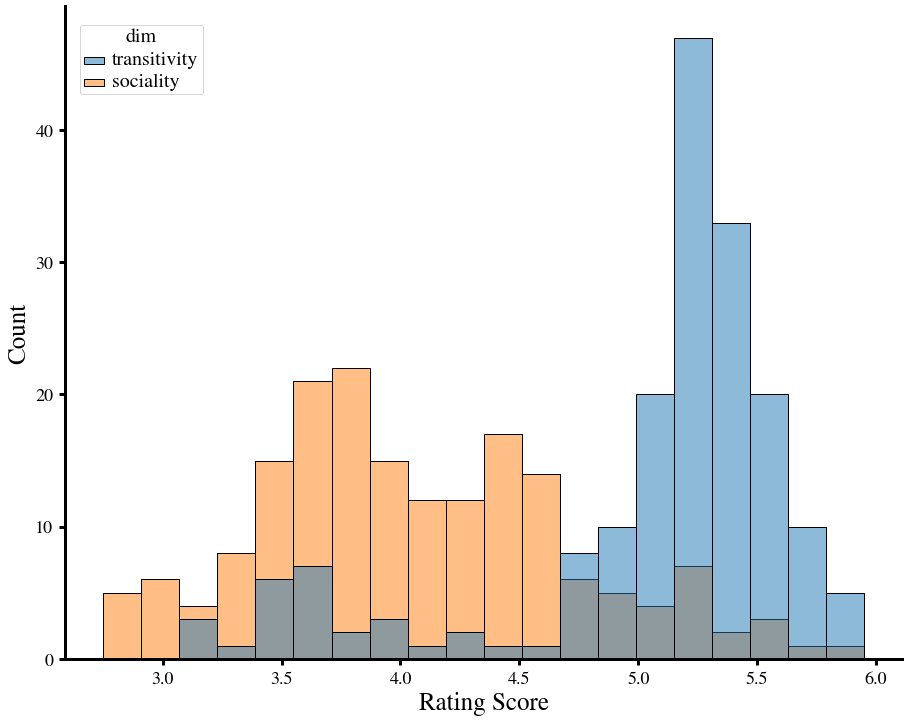

In [32]:
import seaborn as sns

plt.figure(figsize=(15, 12))

ax = sns.histplot(data=beh_df, x="mean_score", hue="dim", bins=20)
# for legend text
# Add some text for labels, title and custom x-axis tick labels, etc.
plt.xlabel('Rating Score', fontsize=25)
plt.ylabel('Count', fontsize=25)

# ax.legend(handles=ax.legend_.legendHandles, labels=[t.get_text() for t in ax.legend_.texts],
#           title=ax.legend_.get_title().get_text(),
#           loc='upper left', fontsize=15)
plt.setp(ax.legend_.get_texts(), fontsize='20') # for legend text
plt.setp(ax.legend_.get_title(), fontsize='20') # for legend title
ax.legend_.set_bbox_to_anchor((0.17, 0.98)) # left → right, down → up

ax.tick_params(labelsize=18, width=3, length=6, direction="out", pad=6)
# ax.set_xlim(-0.6, 2.5)
# ax.set_ylim(0, 0.75)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(3)
ax.spines['left'].set_linewidth(3)

#### Generate brain map using contrast substraction

In [ ]:
dims = ['transitivity', 'sociality']
brain_map = np.zeros((2, beta_sum.shape[1]))
for dim_idx, dim in enumerate(dims):
    # get label
    dim_score = beh_df.loc[beh_df['dim']==dim, 'mean_score'].to_numpy()
    dim_content = np.array([1 if item > 4 else 0 for item in dim_score])
    # # compute brain map
    brain_map = np.zeros((1, 91282))
    brain_map[0, :59412] = beta_sum[dim_content==1].mean(axis=0) - beta_sum[dim_content==0].mean(axis=0)
    save_ciftifile(brain_map, pjoin(result_path, f'{dim}_map.dtseries.nii'))
    print('%s map threshold: left: %.2f; right: %.2f'%(dim, brain_map.squeeze()[:59412].mean() - brain_map.squeeze()[:59412].std(),
                                                       brain_map.squeeze()[:59412].mean() + brain_map.squeeze()[:59412].std()))


: 

#### Generate brain map using correlation

In [6]:
from scipy.stats import pearsonr
import subprocess

dims = ['transitivity', 'sociality']
brain_map = np.zeros((2, beta_sum.shape[1]))
p_value = 0.01
smooth_kernel = 8

for dim_idx, dim in enumerate(dims):
    # get label
    dim_score = beh_df.loc[beh_df['dim']==dim, 'mean_score'].to_numpy()
    # # compute brain map
    brain_map = np.zeros((1, 91282))
    for voxel_idx in range(59412):
        corr_info = pearsonr(beta_sum[:, voxel_idx], dim_score)
        if corr_info[1] < p_value:
            brain_map[0, voxel_idx] = corr_info[0]
    # smooth the target map
    out_file = pjoin(result_path, 'brain_map', f'{dim}_map_corr_smooth-p_{p_value}.dtseries.nii')
    save_ciftifile(brain_map, out_file)
    fsl_cmd = f'fslmaths {out_file} -s {smooth_kernel} -save'
    subprocess.check_call(fsl_cmd, shell=True)
